In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


In [3]:
#read data into dataframes
df_sensors = pd.read_csv('data\dane_z_czujnikow.csv', sep=';')
df_inverters = pd.read_csv('data\dane_z_falownikow.csv', sep=';')
df_positions = pd.read_csv('data\dane_z_czujnikow_z_planow_farmy.csv', sep=';')


In [4]:
#drop accidental empty column
df_positions.drop('Unnamed: 2', axis=1, inplace=True)

In [5]:
def round_time(df):
    df['time'] = pd.to_datetime(df['time'])
    df['time'] = df['time'].dt.round('5min')
    df['time'] = df['time'].dt.time

#function filtering records that are out of bounds for a given record
def verify_bounds(sensor_df, column_name, output_name, min_range, max_range, error):
    filtered_df_below = sensor_df[min_range - error > sensor_df[column_name]]
    filtered_df_above = sensor_df[sensor_df[column_name] > max_range + error]
    filtered_df = pd.concat([filtered_df_below, filtered_df_above])
    return filtered_df[[output_name]]

#function that returns elements that are present in df1 and not in df2
def find_missing_devices(df_searched, df_with_records_to_find, identifier_column):
    result = pd.merge(df_searched, df_with_records_to_find, on=identifier_column, how='left', indicator=True)
    result = result[result['_merge'] == 'left_only']
    result = result.drop(columns='_merge')
    return result[[identifier_column]]  

def raise_error_status(df, df_errors, error_code):
    for index, _ in df_errors.iterrows():
        df.at[index, 'status'] += error_code
    return df

def recreate_missing_values(df, id_of_object_missing_data):

    original_filtered = df[df['sensor_number'] == id_of_object_missing_data]

    start_date = '06:05:00'
    end_date = '15:20:00'
    time_range = pd.date_range(start=start_date, end=end_date, freq='5T')
    time_range = time_range.time
    
    default_values = {'sensor_number': id_of_object_missing_data,
                      'panel_voltage': None,
                      'panel_currency':None,
                      'panel_temperature':None,
                      'signal_power':None,
                       'status': 16
                       }  # Define default values
    time_series = pd.Series(data=time_range, name='time')
    default_df = pd.DataFrame(index=time_series, data=default_values)
    original_filtered.set_index('time', inplace=True)
    default_df.update(original_filtered)
    default_df.reset_index(inplace=True)
    
    original_filtered_without_incomplete_data = df[df['sensor_number'] != id_of_object_missing_data]
    return pd.concat([default_df, original_filtered_without_incomplete_data])

def convert_to_timestamp(time_obj):
    return datetime.combine(datetime.today(), time_obj).timestamp()  / 1000


In [6]:
round_time(df_sensors)
round_time(df_inverters)

C:\Users\buchwald\AppData\Local\Temp\ipykernel_15768\1599422620.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['time'])
C:\Users\buchwald\AppData\Local\Temp\ipykernel_15768\1599422620.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['time'])


In [13]:
def plot_sensor(df, id, column_name):    
    df_plot_sample = df[df['sensor_number'] == id]
    df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)
    plt.plot(df_plot_sample['time'], df_plot_sample[column_name])
    plt.xlabel('')
    plt.ylabel(column_name)
    plt.title('Plot of sensor ' + column_name)
    plt.show()

def plot_inverter(df, id, column_name):
    df_plot_sample = df[df['inverter_number'] == id]
    df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)
    plt.plot(df_plot_sample['time'], df_plot_sample[column_name])
    plt.xlabel('')
    plt.ylabel(column_name)
    plt.title('Plot of inverter ' + column_name)
    plt.show()

def plot_inverter_no_show(df, id, column_name):
    df_plot_sample = df[df['inverter_number'] == id]
    df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)
    plt.plot(df_plot_sample['time'], df_plot_sample[column_name])
    plt.xlabel('')
    plt.ylabel(column_name)
    plt.title('Plot of inverter ' + column_name)

C:\Users\buchwald\AppData\Local\Temp\ipykernel_29036\858041967.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)


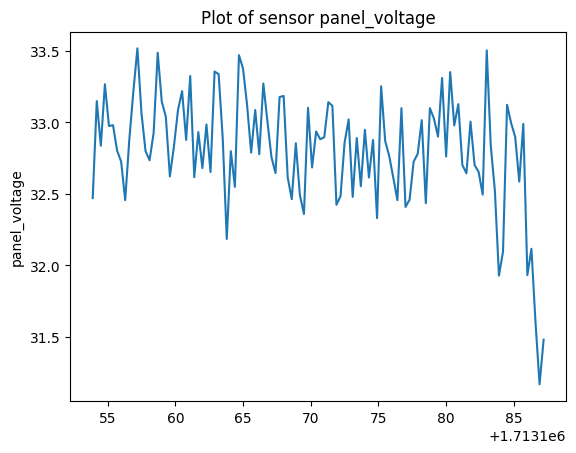

C:\Users\buchwald\AppData\Local\Temp\ipykernel_29036\858041967.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)


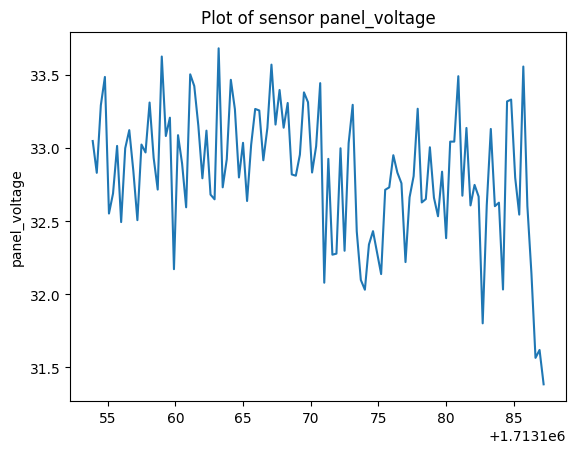

C:\Users\buchwald\AppData\Local\Temp\ipykernel_29036\858041967.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)


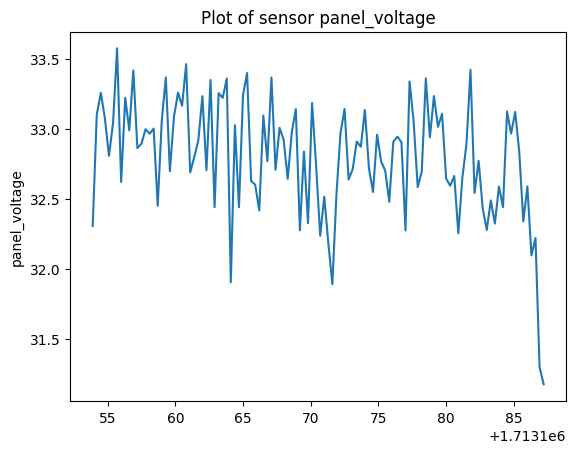

C:\Users\buchwald\AppData\Local\Temp\ipykernel_29036\858041967.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)


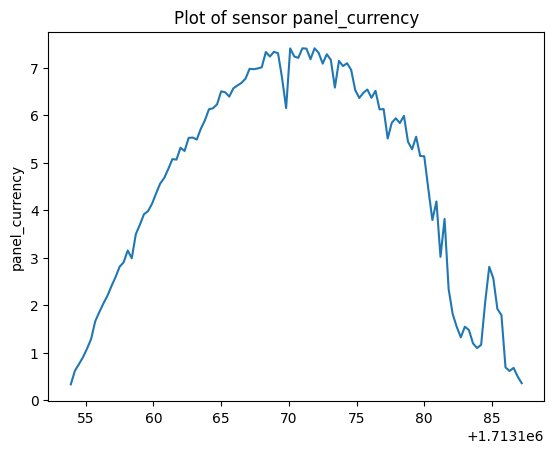

C:\Users\buchwald\AppData\Local\Temp\ipykernel_29036\858041967.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)


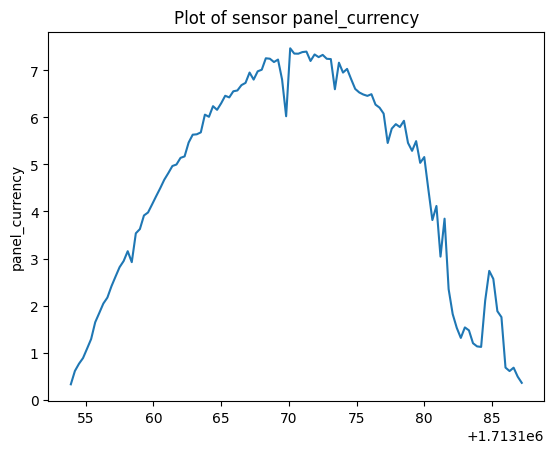

C:\Users\buchwald\AppData\Local\Temp\ipykernel_29036\858041967.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)


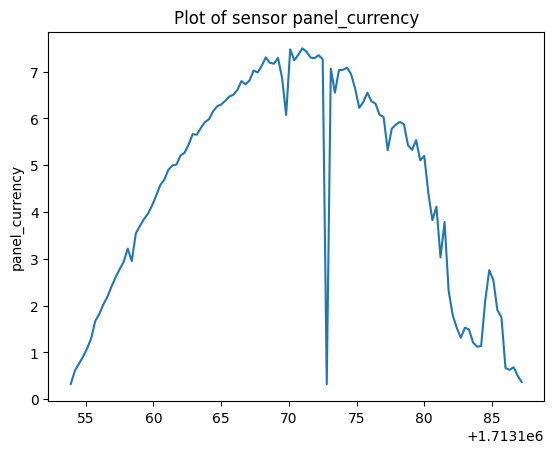

In [59]:
plot_sensor(df_sensors, 1337, 'panel_voltage')
plot_sensor(df_sensors, 1338, 'panel_voltage')
plot_sensor(df_sensors, 1336, 'panel_voltage')

plot_sensor(df_sensors, 1337, 'panel_currency')
plot_sensor(df_sensors, 1338, 'panel_currency')
plot_sensor(df_sensors, 1336, 'panel_currency')

C:\Users\buchwald\AppData\Local\Temp\ipykernel_29036\858041967.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)


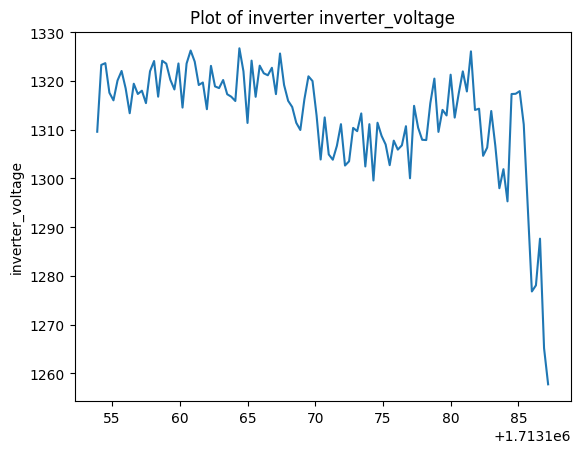

C:\Users\buchwald\AppData\Local\Temp\ipykernel_29036\858041967.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)


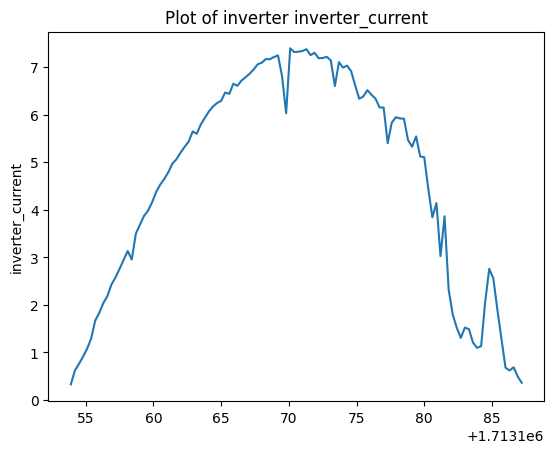

C:\Users\buchwald\AppData\Local\Temp\ipykernel_29036\858041967.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)


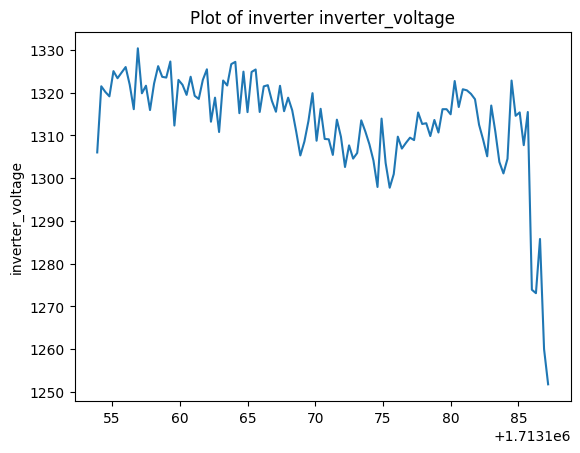

C:\Users\buchwald\AppData\Local\Temp\ipykernel_29036\858041967.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)


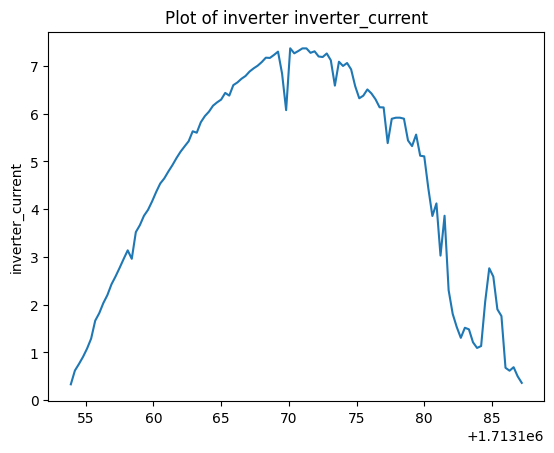

C:\Users\buchwald\AppData\Local\Temp\ipykernel_29036\858041967.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)


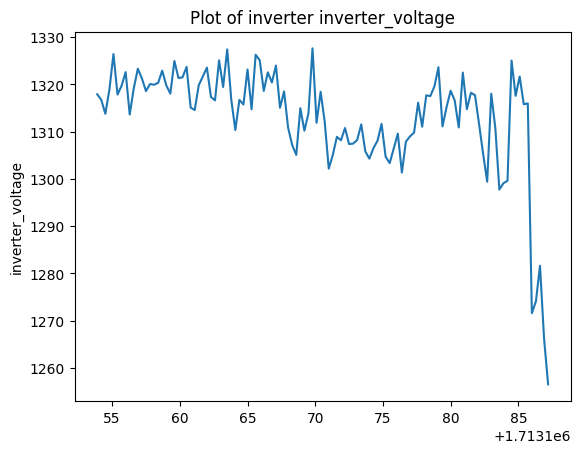

C:\Users\buchwald\AppData\Local\Temp\ipykernel_29036\858041967.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)


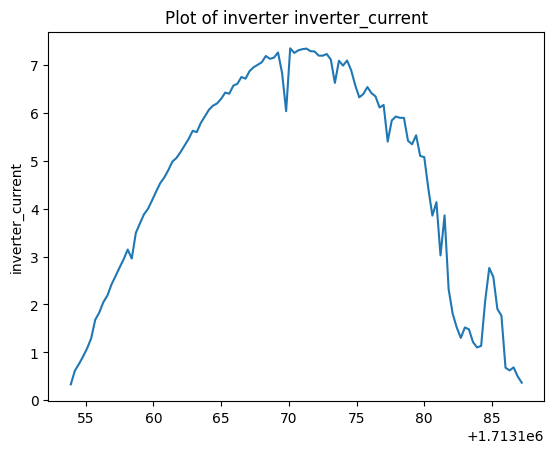

In [52]:
plot_inverter(df_inverters, 24, 'inverter_voltage')
plot_inverter(df_inverters, 24, 'inverter_current')

plot_inverter(df_inverters, 23, 'inverter_voltage')
plot_inverter(df_inverters, 23, 'inverter_current')

plot_inverter(df_inverters, 25, 'inverter_voltage')
plot_inverter(df_inverters, 25, 'inverter_current')


In [8]:
#Checking parameters for sensors
invalid_sensors_voltage = verify_bounds(df_sensors, 'panel_voltage', 'sensor_number', min_range=0, max_range=39.1, error=0.5)
invalid_sensors_current = verify_bounds(df_sensors, 'panel_currency', 'sensor_number', min_range=0, max_range=9.15, error=0.2)
invalid_sensors_temperature = verify_bounds(df_sensors, 'panel_temperature', 'sensor_number', min_range=-40, max_range=120, error=1)

df_sensors_missing_from_the_farm = find_missing_devices(df_sensors, df_positions, 'sensor_number')
df_sensors_of_unknown_origin = find_missing_devices(df_positions, df_sensors, 'sensor_number')

# checking if sensors were not dropping packets. 
# for our timeframe there should be 112 measurements
# sensors 1714, 1724 missed one packet each
df_sensors['sensor_number'].value_counts()

df_sensors['status'] = 0 
df_sensors = raise_error_status(df_sensors, invalid_sensors_voltage, 1)
df_sensors = raise_error_status(df_sensors, invalid_sensors_current, 2)
df_sensors = raise_error_status(df_sensors, invalid_sensors_temperature, 4)
df_sensors = raise_error_status(df_sensors, df_sensors_of_unknown_origin, 8)
df_sensors = recreate_missing_values(df_sensors, 1714)
df_sensors = recreate_missing_values(df_sensors, 1724)
df_sensors = recreate_missing_values(df_sensors, 54)
df_sensors = recreate_missing_values(df_sensors, 1666)
df_sensors[df_sensors['status'] > 0]


,time,sensor_number,panel_voltage,panel_currency,panel_temperature,signal_power,status
0,06:05:00,54,None,None,None,None,16
1,06:10:00,54,None,None,None,None,16
2,06:15:00,54,None,None,None,None,16
3,06:20:00,54,None,None,None,None,16
4,06:25:00,54,None,None,None,None,16
...,...,...,...,...,...,...,...
222634,15:20:00,858,31.583484,0.355887,-2000.0,-3.578061,4
223093,15:20:00,1318,31.173979,0.357905,-33333.0,6.623326,4
223279,15:20:00,1504,31.701001,44.0,10.63,-3.754358,2
223570,15:20:00,1795,31.409635,50.0,9.61,5.505208,2


In [9]:
#Checking parameters for inverters

invalid_inverters_voltage_not_working = df_inverters[df_inverters['inverter_voltage'] < 200]
invalid_inverters_voltage_not_working = invalid_inverters_voltage_not_working[invalid_inverters_voltage_not_working['inverter_voltage'] > 20]                          
invalid_inverters_voltage_line_break = df_inverters[df_inverters['inverter_voltage'] < 20]
invalid_inverters_voltage_line_break = invalid_inverters_voltage_line_break[invalid_inverters_voltage_line_break['inverter_voltage'] > 0] 
invalid_inverters_voltage = verify_bounds(df_inverters, 'inverter_voltage', 'inverter_number', min_range=0, max_range=2500, error=20)
invalid_inverters_current = verify_bounds(df_inverters, 'inverter_current', 'inverter_number', min_range=0, max_range=20, error=0.1)

df_inverters_missing_from_the_farm =find_missing_devices(df_inverters, df_positions, 'inverter_number')
df_inverters_of_unknown_origin =find_missing_devices(df_positions, df_inverters, 'inverter_number')

# checking if sensors were not dropping packets. 
# for our timeframe there should be 112 measurements
# sensors 24, 33 missed one packet each
df_inverters['inverter_number'].value_counts()


df_inverters['status'] = 0
df_inverters = raise_error_status(df_inverters, invalid_inverters_voltage_not_working, 1)
df_inverters = raise_error_status(df_inverters, invalid_inverters_voltage_line_break, 2)
df_inverters = raise_error_status(df_inverters, invalid_inverters_voltage, 4)
df_inverters = raise_error_status(df_inverters, invalid_inverters_current, 8)
df_inverters[df_inverters['status'] > 0]


,time,inverter_number,inverter_voltage,inverter_current,status
115,06:15:00,16,3333.000000,0.755437,4
3427,11:45:00,28,1304.459383,50.000000,8
5348,14:55:00,60,-1000.000000,1.775472,4


In [27]:
invalid_inverters_voltage_line_break

,time,inverter_number,inverter_voltage,inverter_current


In [28]:
print("invalid sensors")
print(invalid_sensors_voltage)
print(invalid_sensors_current)
print(invalid_sensors_temperature)
print(df_sensors_of_unknown_origin)
print(df_sensors_missing_from_the_farm)
print("invalid inverters")
print(invalid_inverters_voltage)
print(invalid_inverters_current)
print(df_inverters_missing_from_the_farm)
print(df_inverters_of_unknown_origin)

invalid sensors
        sensor_number
9268             1279
223763           1988
2423              427
        sensor_number
223279           1504
223570           1795
        sensor_number
222634            858
223093           1318
220264            486
        sensor_number
5936               54
130369           1166
        sensor_number
173826              0
175823           3333
invalid inverters
      inverter_number
5348               60
115                16
      inverter_number
3427               28
        inverter_number
213920               60
213921               60
Empty DataFrame
Columns: [inverter_number]
Index: []


In [29]:
df_sensors['sensor_number']

0         1724
1         1724
2         1724
3         1724
4         1724
          ... 
223771    1996
223772    1997
223773    1998
223774    1999
223775    2000
Name: sensor_number, Length: 223778, dtype: int64

In [ ]:
#task 3

In [12]:
#Establish lines
df_lines = pd.merge(df_sensors, df_positions, on='sensor_number')

agg_funcs = {'panel_voltage': 'sum', 'panel_currency': lambda x: x.mean()}
df_lines = df_lines.groupby(['inverter_number', 'time']).agg(agg_funcs).reset_index()
df_lines


,inverter_number,time,panel_voltage,panel_currency
0,1,06:05:00,396.941069,0.329247
1,1,06:10:00,395.791791,0.617391
2,1,06:15:00,396.000544,0.758039
3,1,06:20:00,395.709608,0.908104
4,1,06:25:00,395.136336,1.081112
...,...,...,...,...
5595,50,15:00:00,1273.859137,0.677185
5596,50,15:05:00,1278.384069,0.618536
5597,50,15:10:00,1283.067518,0.684520
5598,50,15:15:00,1270.17367,0.495768


C:\Users\buchwald\AppData\Local\Temp\ipykernel_15768\1483590624.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)
C:\Users\buchwald\AppData\Local\Temp\ipykernel_15768\1483590624.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)


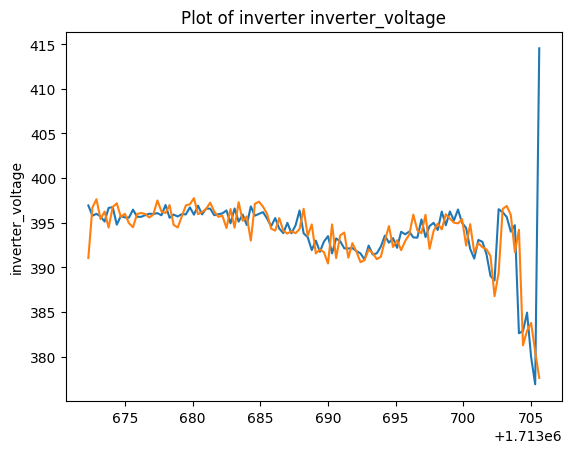

In [14]:
plot_inverter_no_show(df=df_lines, column_name='panel_voltage', id=1)
plot_inverter_no_show(df=df_inverters, column_name='inverter_voltage', id=1)
plt.show()


C:\Users\buchwald\AppData\Local\Temp\ipykernel_15768\1483590624.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)
C:\Users\buchwald\AppData\Local\Temp\ipykernel_15768\1483590624.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)


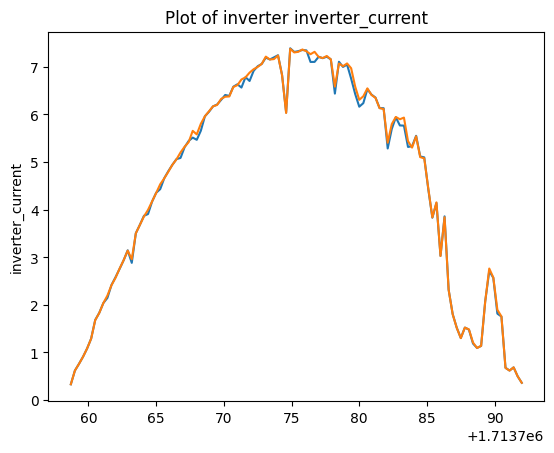

In [16]:
plot_inverter_no_show(df=df_lines, column_name='panel_currency', id=1)
plot_inverter_no_show(df=df_inverters, column_name='inverter_current', id=1)
plt.show()


In [21]:
df_lines_current_min = pd.merge(df_sensors, df_positions, on='sensor_number')
df_lines_current_max = df_lines_current_min.copy()
df_lines_voltage_min = df_lines_current_min.copy()
df_lines_voltage_max = df_lines_current_min.copy()

voltage_error = 0.5
current_error = 0.2

df_lines_current_max['panel_currency'] += current_error
df_lines_current_min['panel_currency'] -= current_error
df_lines_voltage_max['panel_voltage'] += voltage_error
df_lines_voltage_min['panel_voltage'] -= voltage_error


df_lines_current_max = df_lines_current_max.groupby(['inverter_number', 'time']).agg(agg_funcs).reset_index()
df_lines_current_min = df_lines_current_min.groupby(['inverter_number', 'time']).agg(agg_funcs).reset_index()
df_lines_voltage_max = df_lines_voltage_max.groupby(['inverter_number', 'time']).agg(agg_funcs).reset_index()
df_lines_voltage_min = df_lines_voltage_min.groupby(['inverter_number', 'time']).agg(agg_funcs).reset_index()

df_inverters_min_voltage = df_inverters.copy()
df_inverters_max_voltage = df_inverters.copy()
df_inverters_min_current = df_inverters.copy()
df_inverters_max_current = df_inverters.copy()

voltage_error = 20
current_error = 0.1
df_inverters_max_current['inverter_current'] += current_error
df_inverters_min_current['inverter_current'] -= current_error
df_inverters_max_voltage['inverter_voltage'] += voltage_error
df_inverters_min_voltage['inverter_voltage'] -= voltage_error







In [30]:
def check_if_below_lower_bounds(df1, df2, df1_col_name, df2_col_name):
    merged_df = pd.merge(df1, df2, on=['inverter_number', 'time'], )
    return merged_df[merged_df[df1_col_name] < merged_df[df2_col_name]]

def check_if_above_upper_bounds(df1, df2, df1_col_name, df2_col_name):
    merged_df = pd.merge(df1, df2, on=['inverter_number', 'time'], )
    return merged_df[merged_df[df1_col_name] < merged_df[df2_col_name]]

In [31]:
check_if_below_lower_bounds(df_lines_voltage_max, df_inverters_min_voltage, 'panel_voltage', 'inverter_voltage')
check_if_below_lower_bounds(df_lines_current_max, df_inverters_min_current, 'panel_currency', 'inverter_current')
check_if_above_upper_bounds(df_lines_voltage_min, df_inverters_max_voltage, 'panel_voltage', 'inverter_voltage')
check_if_above_upper_bounds(df_lines_current_max, df_inverters_max_current, 'panel_currency', 'inverter_current')

,inverter_number,time,panel_voltage,panel_currency,inverter_voltage,inverter_current,status
22,1,07:55:00,395.703283,4.629677,394.469972,4.632569,0
27,1,08:20:00,396.912495,5.285206,395.963972,5.300814,0
30,1,08:35:00,396.580856,5.712676,397.259119,5.754198,0
31,1,08:40:00,395.846295,5.666263,396.250770,5.680361,0
32,1,08:45:00,395.95604,5.856621,395.672017,5.903169,0
...,...,...,...,...,...,...,...
5563,50,12:30:00,1309.808047,6.186679,1310.242001,6.251847,0
5566,50,12:45:00,1309.900847,5.839580,1315.450782,6.041283,0
5569,50,13:00:00,1315.293387,5.374919,1312.670260,5.512136,0
5570,50,13:05:00,1315.384803,5.424401,1315.700717,5.458184,0


C:\Users\buchwald\AppData\Local\Temp\ipykernel_15768\1483590624.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)
C:\Users\buchwald\AppData\Local\Temp\ipykernel_15768\1483590624.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)
C:\Users\buchwald\AppData\Local\Temp\ipykernel_15768\1483590624.py:21: SettingWithCopyWarning: 
A value is trying to be set on

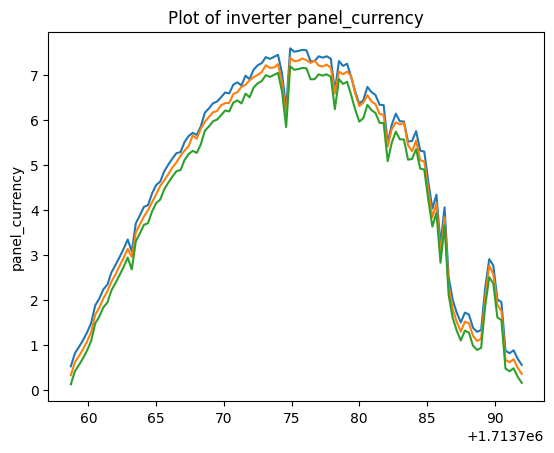

C:\Users\buchwald\AppData\Local\Temp\ipykernel_15768\1483590624.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)
C:\Users\buchwald\AppData\Local\Temp\ipykernel_15768\1483590624.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_sample['time'] = df_plot_sample['time'].apply(convert_to_timestamp)
C:\Users\buchwald\AppData\Local\Temp\ipykernel_15768\1483590624.py:21: SettingWithCopyWarning: 
A value is trying to be set on

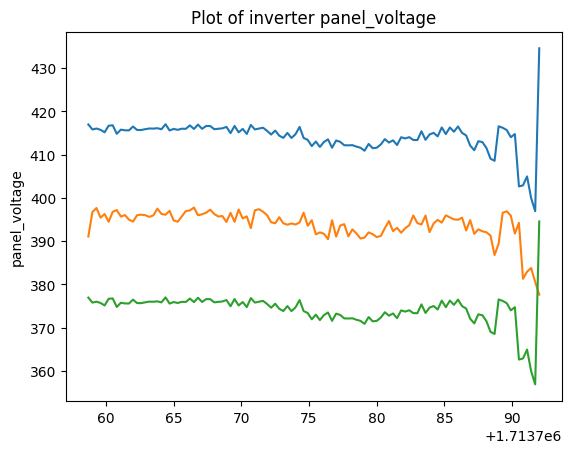

In [18]:
plot_inverter_no_show(df=df_lines_current_max, column_name='panel_currency', id=1)
plot_inverter_no_show(df=df_inverters, column_name='inverter_current', id=1)
plot_inverter_no_show(df=df_lines_current_min, column_name='panel_currency', id=1)
plt.show()

plot_inverter_no_show(df=df_lines_voltage_max, column_name='panel_voltage', id=1)
plot_inverter_no_show(df=df_inverters, column_name='inverter_voltage', id=1)
plot_inverter_no_show(df=df_lines_voltage_min, column_name='panel_voltage', id=1)
plt.show()